In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pckl
%matplotlib inline
sns.set_style("whitegrid")

import os

In [3]:
import sys
sys.path.append('../code/')

In [55]:
#get good signature threshold
bname='gdsc'
abstype='_abs'
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
scores=[]
for fname in datasets:
    data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bname,fname,abstype),
                     sep=',',header=0,index_col=0)
    scores+=list(data.values.reshape((1,-1))[0])
scores=np.array(scores)
th=np.std(scores)*2.5
for fname in datasets:
    data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bname,fname,abstype),
                     sep=',',header=0,index_col=0)
    
    

In [61]:
data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bname,'BEST_dorothea_AB',abstype),
                     sep=',',header=0,index_col=0)
th=np.std(scores)*2.5
(data.abs()>th)*1

,AR,ARNTL,ATF1,ATF2,ATF4,BACH1,CDX2,CEBPA,CEBPB,CEBPD,...,TFDP1,TP63,TWIST1,USF1,USF2,VDR,WT1,YY1,ZBTB33,ZEB1
ACVR2A_mut,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AKAP9_mut,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALK_mut,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANK3_mut,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
APC_mut,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
ARFGEF1_mut,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARHGAP29_mut,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARID1A_mut,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARID2_mut,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARID4A_mut,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
meta=pd.read_csv('../results/benchmark/datasets/tcga_meta.csv',sep=',',header=0,index_col=0)
#meta.index=pd.Series(meta.index).apply(lambda x:x.replace('-','.')).values

In [142]:
meta.loc[data.loc['HIF1A'].sort_values().index]

,TCGA,Tumor
TCGA.BQ.7061.01A.11R.1965.07,KIRP,1
TCGA.DD.A119.01A.11R.A131.07,LIHC,1
TCGA.05.5428.01A.01R.1628.07,LUAD,1
TCGA.49.4510.01A.01R.1206.07,LUAD,1
TCGA.HC.8265.01B.04R.2302.07,PRAD,1
TCGA.44.4112.01B.06R.A277.07,LUAD,1
TCGA.AA.3956.01A.02R.1022.07,COAD,1
TCGA.BK.A139.01A.11R.A277.07,UCEC,1
TCGA.KK.A59Z.01A.12R.A26U.07,PRAD,1
TCGA.97.7546.01A.11R.2039.07,LUAD,1


In [163]:
scores=pd.read_csv('../results/benchmark/z_scores/tcga/single/BEST_dorothea_AB_filtered.csv',sep=',',header=0,index_col=0)

In [174]:
meta.loc[gex.loc['VEGFA'].sort_values().index]

,TCGA,Tumor
TCGA-B0-5707-01A-11R-1541-07,KIRC,1
TCGA-ET-A4KN-01A-11R-A250-07,THCA,1
TCGA-CW-6087-01A-11R-1672-07,KIRC,1
TCGA-A3-3363-01A-01R-0864-07,KIRC,1
TCGA-G9-6365-01A-11R-1789-07,PRAD,1
TCGA-B8-4621-01A-01R-1503-07,KIRC,1
TCGA-G9-6361-01A-21R-1965-07,PRAD,1
TCGA-CZ-5457-11A-01R-1503-07,KIRC,0
TCGA-B0-4698-01A-01R-1503-07,KIRC,1
TCGA-B0-4712-11A-02R-1503-07,KIRC,0


In [165]:
gex=pd.read_csv('../results/benchmark/datasets/tcga_data.csv',sep=',',header=0,index_col=0)

In [175]:
gex.loc['VEGFA'].sort_values()

TCGA-B0-5707-01A-11R-1541-07   -8.625
TCGA-ET-A4KN-01A-11R-A250-07   -8.215
TCGA-CW-6087-01A-11R-1672-07   -7.425
TCGA-A3-3363-01A-01R-0864-07   -7.412
TCGA-G9-6365-01A-11R-1789-07   -6.935
TCGA-B8-4621-01A-01R-1503-07   -6.887
TCGA-G9-6361-01A-21R-1965-07   -6.738
TCGA-CZ-5457-11A-01R-1503-07   -6.711
TCGA-B0-4698-01A-01R-1503-07   -6.452
TCGA-B0-4712-11A-02R-1503-07   -6.425
TCGA-T7-A92I-01A-11R-A37O-07   -6.270
TCGA-CZ-4863-11A-01R-1503-07   -6.254
TCGA-E8-A242-01A-21R-A16R-07   -6.202
TCGA-EJ-7315-01A-31R-2118-07   -6.197
TCGA-G9-6347-01A-11R-A31N-07   -6.138
TCGA-H9-7775-01A-11R-2118-07   -5.910
TCGA-CZ-4865-11A-01R-1503-07   -5.901
TCGA-B0-5701-11A-01R-1541-07   -5.871
TCGA-CZ-5989-11A-01R-1672-07   -5.866
TCGA-KN-8427-01A-11R-2315-07   -5.818
TCGA-B2-4098-01A-02R-1325-07   -5.804
TCGA-CZ-5462-11A-01R-1503-07   -5.758
TCGA-CZ-5987-11A-01R-1672-07   -5.715
TCGA-CZ-5453-11A-01R-1503-07   -5.692
TCGA-EL-A3ZM-01A-12R-A23N-07   -5.667
TCGA-CW-5591-01A-01R-1541-07   -5.622
TCGA-CZ-5463

In [7]:
for geneset in ['KEGG','BIOCARTA','REACTOME']:
    make_genesets.make_overlap_gene_sets(geneset,'dorothea_AB')

In [94]:
for geneset1 in ['KEGG','BIOCARTA','REACTOME']:
    for geneset2 in ['KEGG','BIOCARTA','REACTOME']:
        if geneset1<geneset2:
            make_genesets.make_overlap_gene_sets(geneset1,geneset2)

In [3]:
#run_viper.R helper_merge_benchmark.py benchmark_progeny.py

In [11]:
#check the random distribution of ROC AUCs
results=pd.read_csv('../results/benchmark/rocaucs/progeny/single/random_dist.csv',sep=',',header=0,index_col=0)
progeny=pd.read_csv('../results/benchmark/datasets/progeny_meta.csv',
                        sep=',',header=0,index_col=0)
progeny=progeny['pathway'].value_counts()
progeny=progeny[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=progeny

In [12]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/rocaucs/progeny/overlap//')
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/progeny/overlap//'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/progeny/overlap//%s.csv' % method, sep=',')

In [199]:
results=pd.read_csv('../results/benchmark/rocaucs/tcga/single/random_dist.csv',sep=',',header=0,index_col=0)
tcga=pd.read_csv('../results/benchmark/datasets/tcga_meta.csv',
                        sep=',',header=0,index_col=0)
tcga=tcga['TCGA'].value_counts()
tcga=tcga[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=tcga

In [201]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/rocaucs/tcga/overlap/')
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/tcga/overlap/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/tcga/overlap/%s.csv' % method, sep=',')

In [21]:
dname1='dorothea_AB'
dname2='BIOCARTA'
bname='progeny'
abs_type=True
size_fil=False
th=4.5

In [22]:
if abs_type:
    activity1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_abs.csv' % (bname,dname1),
                              sep=',',header=0,index_col=0).abs().max()
    activity2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_abs.csv' % (bname,dname2),
                              sep=',',header=0,index_col=0).abs().max()
else:
    activity1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s.csv' % (bname,dname1),
                              sep=',',header=0,index_col=0).abs().max()
    activity2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s.csv' % (bname,dname2),
                              sep=',',header=0,index_col=0).abs().max()

In [23]:
good1=activity1.index[activity1>th]
good2=activity2.index[activity2>th]

In [24]:
if dname1<dname2:
    overlap_name=dname1+'_overlap_'+dname2
else:
    overlap_name=dname2+'_overlap_'+dname1

In [25]:
if abs_type:
    activity1m2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_minus_%s_abs.csv' % (bname,dname1,dname2),
                           sep=',',header=0,index_col=0).abs().max()
    activity2m1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_minus_%s_abs.csv' % (bname,dname2,dname1),
                           sep=',',header=0,index_col=0).abs().max()
    activity1o2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_abs.csv' % (bname,overlap_name),
                           sep=',',header=0,index_col=0).abs().max()
else:
    activity1m2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_minus_%s.csv' % (bname,dname1,dname2),
                           sep=',',header=0,index_col=0).abs().max()
    activity2m1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_minus_%s.csv' % (bname,dname2,dname1),
                           sep=',',header=0,index_col=0).abs().max()
    activity1o2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s.csv' % (bname,overlap_name),
                           sep=',',header=0,index_col=0).abs().max()


In [26]:
activity1m2=pd.DataFrame(activity1m2,columns=['Score'])
if dname1<dname2:
    activity1m2['First']=pd.Series(activity1m2.index).apply(lambda x:x.split('*')[0]).values
    activity1m2['Second']=pd.Series(activity1m2.index).apply(lambda x:x.split('*')[1]).values
else:
    activity1m2['Second']=pd.Series(activity1m2.index).apply(lambda x:x.split('*')[0]).values
    activity1m2['First']=pd.Series(activity1m2.index).apply(lambda x:x.split('*')[1]).values
fil=np.in1d(activity1m2['First'],good1) & np.in1d(activity1m2['Second'],good2)
activity1m2=activity1m2[fil]

In [27]:
activity2m1=pd.DataFrame(activity2m1,columns=['Score'])
if dname1<dname2:
    activity2m1['First']=pd.Series(activity2m1.index).apply(lambda x:x.split('*')[0]).values
    activity2m1['Second']=pd.Series(activity2m1.index).apply(lambda x:x.split('*')[1]).values
else:
    activity2m1['Second']=pd.Series(activity2m1.index).apply(lambda x:x.split('*')[0]).values
    activity2m1['First']=pd.Series(activity2m1.index).apply(lambda x:x.split('*')[1]).values
fil=np.in1d(activity2m1['First'],good1) & np.in1d(activity2m1['Second'],good2)
activity2m1=activity2m1[fil]

In [28]:
activity1o2=pd.DataFrame(activity1o2,columns=['Score'])
if dname1<dname2:
    activity1o2['First']=pd.Series(activity1o2.index).apply(lambda x:x.split('*')[0]).values
    activity1o2['Second']=pd.Series(activity1o2.index).apply(lambda x:x.split('*')[1]).values
else:
    activity1o2['Second']=pd.Series(activity1o2.index).apply(lambda x:x.split('*')[0]).values
    activity1o2['First']=pd.Series(activity1o2.index).apply(lambda x:x.split('*')[1]).values 
fil=np.in1d(activity1o2['First'],good1) & np.in1d(activity1o2['Second'],good2)
activity1o2=activity1o2[fil]

In [29]:
activity1=pd.DataFrame(activity1,columns=['Score'])
activity1['First']=activity1.index
activity1['Second']='None'
fil=np.in1d(activity1['First'],good1)
activity1=activity1[fil]

In [30]:
activity2=pd.DataFrame(activity2,columns=['Score'])
activity2['First']=activity2.index
activity2['Second']='None'
fil=np.in1d(activity2['First'],good2)
activity2=activity2[fil]

In [31]:
if dname1=='dorothea_AB':
    dname1='DoRothEA'
if dname2=='dorothea_AB':
    dname2='DoRothEA'

In [32]:
activity1['Name']=dname1
activity2['Name']=dname2
activity1m2['Name']=dname1+' - '+dname2
activity2m1['Name']=dname2+' - '+dname1
activity1o2['Name']=dname1+' & '+dname2
activity=pd.concat([activity1,activity2,activity1m2,activity2m1,activity1o2])

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [33]:
#fil=activity1o2['Score']>4.5
#activity1o2=activity1o2[fil]
#good1=list(set(activity1o2['First']))
#good2=list(set(activity1o2['Second']))
#activity1=activity1[np.in1d(activity1['First'],good1)]
#activity2=activity2[np.in1d(activity2['First'],good2)]
#activity1m2=activity1m2[np.in1d(activity1m2['First'],good1)&np.in1d(activity1m2['Second'],good2)]
#activity2m1=activity2m1[np.in1d(activity2m1['First'],good1)&np.in1d(activity2m1['Second'],good2)]
#activity=pd.concat([activity1,activity2,activity1m2,activity2m1,activity1o2])

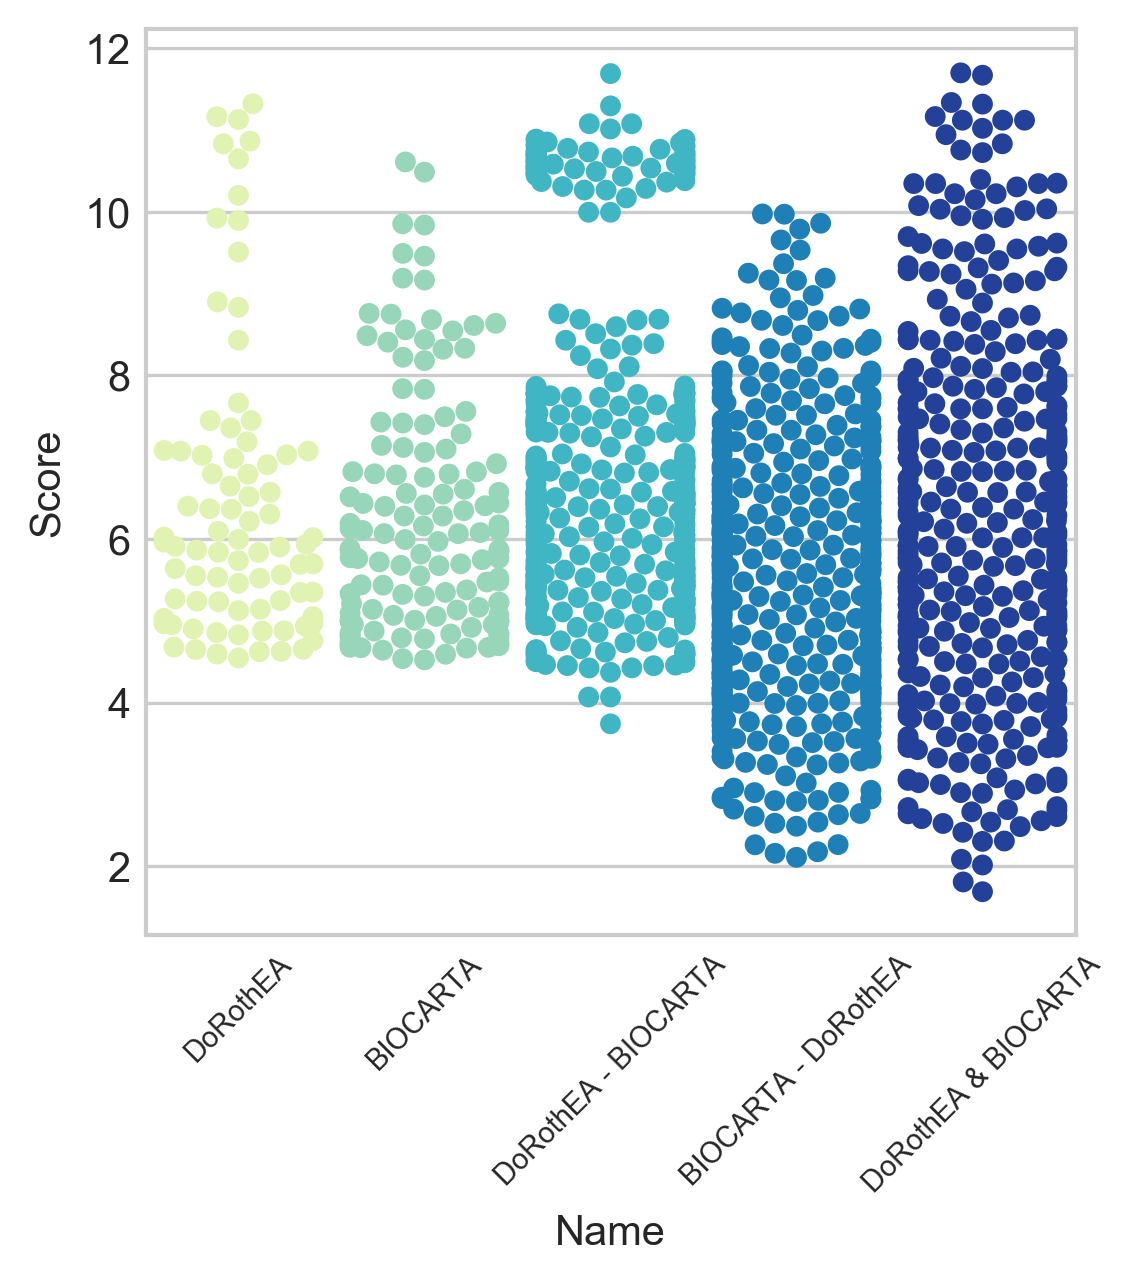

In [35]:
plt.figure(figsize=(4,4),dpi=300)
sns.set_palette('YlGnBu',5)
sns.swarmplot(x='Name',y='Score',data=activity)
plt.xticks(rotation=45,size=7)
plt.savefig('proba.pdf')

In [89]:
from scipy.stats import mannwhitneyu as mwu

In [90]:
print(np.median(activity1['Score']),np.std(activity1['Score']))
print(np.median(activity2['Score']),np.std(activity2['Score']))
print(np.median(activity1m2['Score']),np.std(activity1m2['Score']))
print(np.median(activity2m1['Score']),np.std(activity2m1['Score']))
print(mwu(activity1m2['Score'],activity2m1['Score']))
print(mwu(activity1m2['Score'],activity1['Score']))

5.905152897718466 1.7977746311310923
5.673765687358871 1.537247803045566
6.054560803210022 1.843714209192382
5.989002523318343 1.5356133510813232
MannwhitneyuResult(statistic=435099.5, pvalue=2.623675320323336e-08)
MannwhitneyuResult(statistic=39727.5, pvalue=0.18889299908369955)


MannwhitneyuResult(statistic=435099.5, pvalue=2.623675320323336e-08)

In [182]:
activity2m1.shape

(1008, 4)